In [1]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import numpy as np
import matplotlib.pyplot as plt
import umap
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.pipeline import make_pipeline
from sklearn.metrics import silhouette_score


notes = pd.read_csv('data/processed_notes.csv')
notes

,case_num,processed_notes,initial_note_length,processed_note_length
0,0,year old male come student health clinic compl...,695,563
1,0,year old male recurrent palpitation past month...,424,305
2,0,dillon cleveland year old male patient signifi...,835,571
3,0,year old male complains palpitation started mo...,700,540
4,0,year old male past medical history evaluation ...,948,673
...,...,...,...,...
42141,9,m madden year old female presenting w worst ha...,765,545
42142,9,year old female came complain dull headache as...,634,504
42143,9,m madden year old female present headache day ...,928,661
42144,9,stephanie madden year old woman complaining he...,697,558


### Notes:

- We know that there are 10 patients and 42146 documents. These 10 patients themselves might be clusters. 

- So, remove the 'case_num' column to make the problem completely Unsupervised learning.

- Will have to consider the inclusion of processed_note_length and initial_note_length later.

In [2]:
# setting X and y for modelling

X = notes[['processed_notes', 'initial_note_length', 'processed_note_length']]
y = notes['case_num']
 


# Initialize the vectorizer with 1-grams and other hyperparameters as needed
# Since the preprocessing is already done, we don't need to specify a custom tokenizer or stop words
vectorizer = TfidfVectorizer(ngram_range=(1,1), 
                             min_df = 0.001, 
                             max_df = 0.9)

# Fit and transform th e preprocessed 'pn_history' column to create the DTM
dtm = vectorizer.fit_transform(X['processed_notes'])
dtm_dense = dtm.todense()

# Convert DTM to a DataFrame
dtm_df = pd.DataFrame(dtm_dense, columns=vectorizer.get_feature_names_out())



# Describe the DTM
print("Size of the DTM: ", dtm_df.shape) 
memory_usage = dtm_df.memory_usage(deep=True).sum()
print("Memory usage (in bytes): ", memory_usage)
dtm_df

Size of the DTM:  (42146, 2478)
Memory usage (in bytes):  835502432


,aa,aaf,ab,abd,abdo,abdomen,abdominal,ability,able,abnormal,...,yellow,yellowing,yesterday,yet,yof,yom,young,younger,youngest,yr
0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.182849,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.000000,0.0,0.0,0.090843,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42141,0.0,0.0,0.0,0.137661,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.191541,0.0,0.0,0.0,0.0,0.0,0.0,0.0
42142,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
42143,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.082982,0.0,0.0,0.0,0.0,0.0,0.0,0.0
42144,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.097239,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Notes:

- As predicted in the EDA, the words like year, past, history cannot be found in the Document Term Matrix.



In [3]:
def cluster_score_plots(min_cluster, max_cluster, inertia_values, silhouette_scores, save_name):

    sns.set(style="darkgrid")
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

    # Plot the inertia values
    axes[0].plot(range(min_cluster,max_cluster+1), inertia_values, marker='o') 
    axes[0].set_title('Inertia')
    axes[0].set_xlabel('Number of clusters')
    axes[0].set_ylabel('Inertia')  


    # Plot the silhouette scores
    axes[1].plot(range(min_cluster,max_cluster+1), silhouette_scores, marker='o') 
    axes[1].set_title('Silhouette Score') 
    axes[1].set_xlabel('Number of clusters') 
    axes[1].set_ylabel('Silhouette Score')
    plt.savefig(save_name)
    plt.show()



## Using K-means clustering - On sparse DTM

In [4]:
min_cluster = 3
max_cluster = 14

inertia_values = []
silhouette_scores = []

for num_clust in range(min_cluster,max_cluster+1):
    kmeans = KMeans(n_clusters=num_clust, random_state=42, n_init='auto').fit(dtm)
    cluster_ids, cluster_sizes = np.unique(kmeans.labels_, return_counts=True)
    print(f"Number elements in {num_clust} clusters: {cluster_sizes}")
    inertia_values.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(dtm, kmeans.labels_))


Number elements in 3 clusters: [15628 16769  9749]
Number elements in 4 clusters: [ 9514  9226  9754 13652]
Number elements in 5 clusters: [ 5382  9255  9753 13566  4190]
Number elements in 6 clusters: [ 5376  6743  7507 15348  4189  2983]
Number elements in 7 clusters: [5401 6748 9751 6068 4190  809 9179]
Number elements in 8 clusters: [1962 9765 6188 4190 7430 6892 3447 2272]
Number elements in 9 clusters: [1961 9755 6126 4190 1593 3042 3450 6869 5160]
Number elements in 10 clusters: [1962 9803 6257 4190 1596 4491 3446 2437 2267 5697]
Number elements in 11 clusters: [1962 9841 2603 4189 1596 4491 3445 2439 2268 5217 4095]
Number elements in 12 clusters: [1962 9751 1958 4189  810 4476 3448 2438 2267 1596 4099 5152]
Number elements in 13 clusters: [1962 6535 1958 4189 3219 4476 3448 2438 2265  810 4099 5152 1595]
Number elements in 14 clusters: [1961 6540 1958 4189 3214 4476 3449 2438 2265  810 4099 1417 1595 3735]


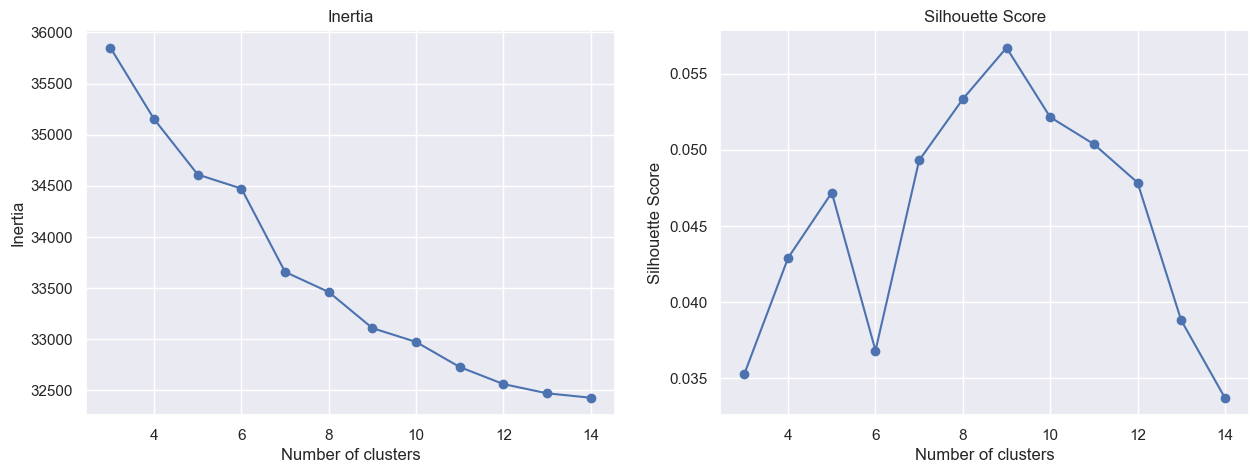

In [5]:
cluster_score_plots(min_cluster, max_cluster, inertia_values, silhouette_scores, 'figs/kmeans_clustering_scores_sparse_dtm.png')


### Notes:

- The inertia plot does not show a proper elbow here, so its not conclusive what is a good value for number of clusters.

- The Silhouettre score plot shows that the best number of clusters are at "number of clusters = 9"

## Dimensionality Reduction

### i. Using TruncatedSVD

In [6]:
from sklearn.decomposition import TruncatedSVD

lsa = TruncatedSVD(n_components=2)
X_lsa = lsa.fit_transform(dtm)

explained_variance = lsa.explained_variance_ratio_.sum()

print(f"Explained variance of the SVD step: {explained_variance * 100:.1f}%")


Explained variance of the SVD step: 3.9%


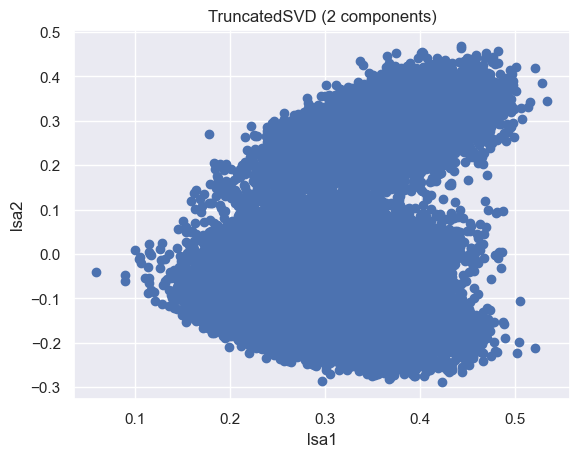

In [7]:
lsa_df = pd.DataFrame(data = X_lsa, columns = ['lsa1', 'lsa2'])

plt.scatter(lsa_df['lsa1'],lsa_df['lsa2'])
plt.xlabel('lsa1')
plt.ylabel('lsa2')
plt.title('TruncatedSVD (2 components)')
plt.savefig('figs/2_component_lsa.png')
plt.show()

### Notes:

- The 2 components have a cumulative explained variance score of 3.9% only.

- This means that we lost 96% of the original variance. 

- Lets see how the k-means clustering goes.

Explained variance of the SVD step: 34.6%
Number elements in 3 clusters: [23321  9074  9751]
Number elements in 4 clusters: [15827  9168  9763  7388]
Number elements in 5 clusters: [12097  9147  9784  6933  4185]
Number elements in 6 clusters: [5399 9185 9766 7414 4190 6192]
Number elements in 7 clusters: [5402 2273 9766 7429 4190 6192 6894]
Number elements in 8 clusters: [9585 3231 2268 6183 6550 4483 2443 7403]
Number elements in 9 clusters: [9586 3208 2268 6059 6545 4478 2443 6750  809]
Number elements in 10 clusters: [9589 3208 2268 6060 6546 4478 2443 1595  809 5150]
Number elements in 11 clusters: [9587 3207 2268 4098 6548 4483 2443 1595  810 5151 1956]
Number elements in 12 clusters: [4189 3211 2269 4098 6545 5405 4471 1595  810 5152 1959 2442]
Number elements in 13 clusters: [4189 2838 2268 4098 1549 5405 4471 1595  810 5150 1959 2442 5372]
Number elements in 14 clusters: [5376 2839 2259 4086 1532 2017 2573 1594  809 5145 1958 2382 5387 4189]


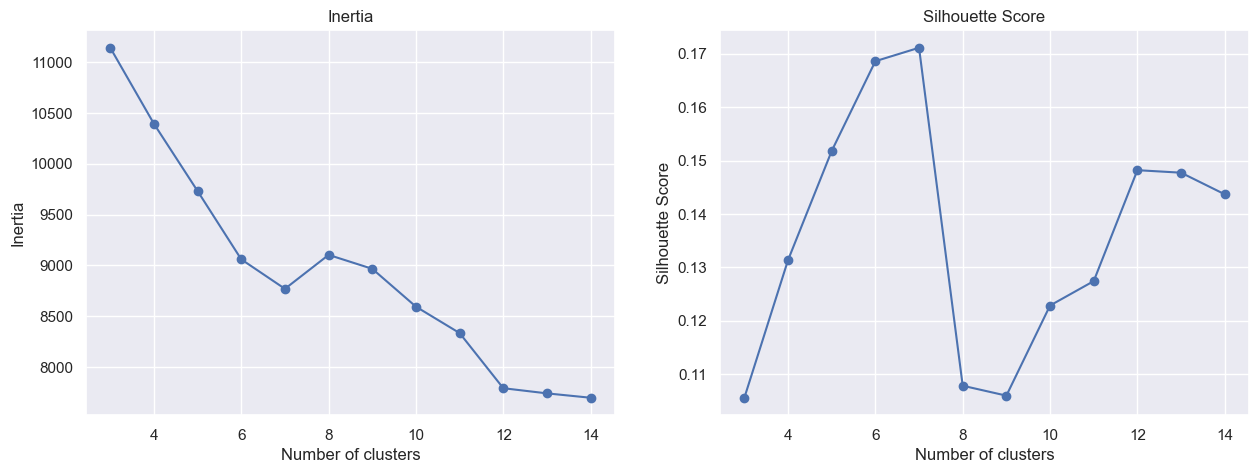

In [8]:
from sklearn.decomposition import TruncatedSVD

lsa = TruncatedSVD(n_components=100)
X_lsa = lsa.fit_transform(dtm)
explained_variance = lsa.explained_variance_ratio_.sum()
print(f"Explained variance of the SVD step: {explained_variance * 100:.1f}%")


inertia_values = []
silhouette_scores = []

for num_clust in range(min_cluster,max_cluster+1):
    kmeans = KMeans(n_clusters=num_clust, random_state=42, n_init='auto').fit(X_lsa)
    cluster_ids, cluster_sizes = np.unique(kmeans.labels_, return_counts=True)
    print(f"Number elements in {num_clust} clusters: {cluster_sizes}")
    
    inertia_values.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_lsa, kmeans.labels_))


cluster_score_plots(min_cluster, max_cluster, inertia_values, silhouette_scores, 'figs/lsa_kmeans_scores.png')

### ii. Using UMAP

/Users/saideepbunny/anaconda3/envs/nlp_env/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


,umap_1,umap_2
0,21.255512,8.733173
1,21.893475,8.232828
2,21.240074,8.010957
3,20.512318,8.023854
4,21.832140,8.100152
...,...,...
42141,2.351455,4.274601
42142,2.457645,6.064574
42143,1.447634,4.983854
42144,1.454219,4.879840


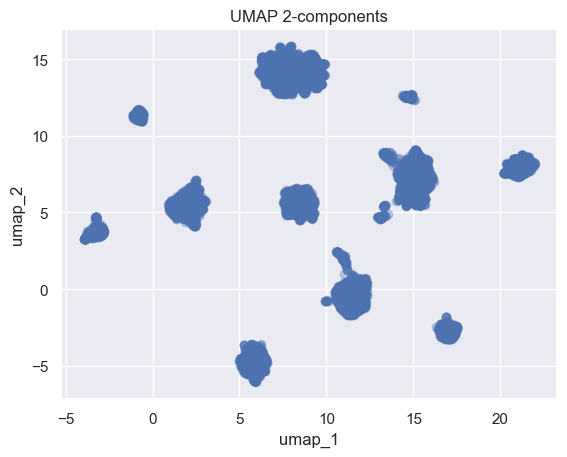

In [9]:
reducer = umap.UMAP(n_neighbors = 5, n_components = 2, metric = 'euclidean', min_dist = 0.05, spread = 1.0, random_state=42)
projected_data = reducer.fit_transform(dtm)

red1 = pd.DataFrame(data=projected_data, columns=['umap_1','umap_2'])
display(red1)

plt.scatter(red1['umap_1'],red1['umap_2'], alpha = 0.3)
plt.title('UMAP 2-components')
plt.xlabel('umap_1')
plt.ylabel('umap_2')
plt.savefig('figs/umap_2_component.png')
plt.show()

- When UMAP is used for dimensionality reduction (2 components), those components have formed 11 noticable clusters.



Number elements in 3 clusters: [20296 10478 11372]
Number elements in 4 clusters: [11520  9679  9413 11534]
Number elements in 5 clusters: [ 7343  9679  9413 11534  4177]
Number elements in 6 clusters: [ 7343  9679  2228  7479  4177 11240]
Number elements in 7 clusters: [7318 9679 2228 7479 4177 4080 7185]
Number elements in 8 clusters: [5384 9679 7479 7185 1959 4055 2228 4177]
Number elements in 9 clusters: [5384 9679 5885 7185 1959 4055 2228 4177 1594]
Number elements in 10 clusters: [5384 9679 5086 7185 1959 4055 2228 4177 1594  799]
Number elements in 11 clusters: [5384 6001 5086 7185 1959 4055 2228 4177 1594  799 3678]
Number elements in 12 clusters: [5384 6001 5086 6880 1959 4055 2228 4177 1594  799 3678  305]
Number elements in 13 clusters: [5384 6001 5086 3975 1959 4055 2228 4177 1594  799 3678  305 2905]
Number elements in 14 clusters: [5384 6001 1982 3975 1959 4055 2228 4177 1594  799 3678  305 2905 3104]


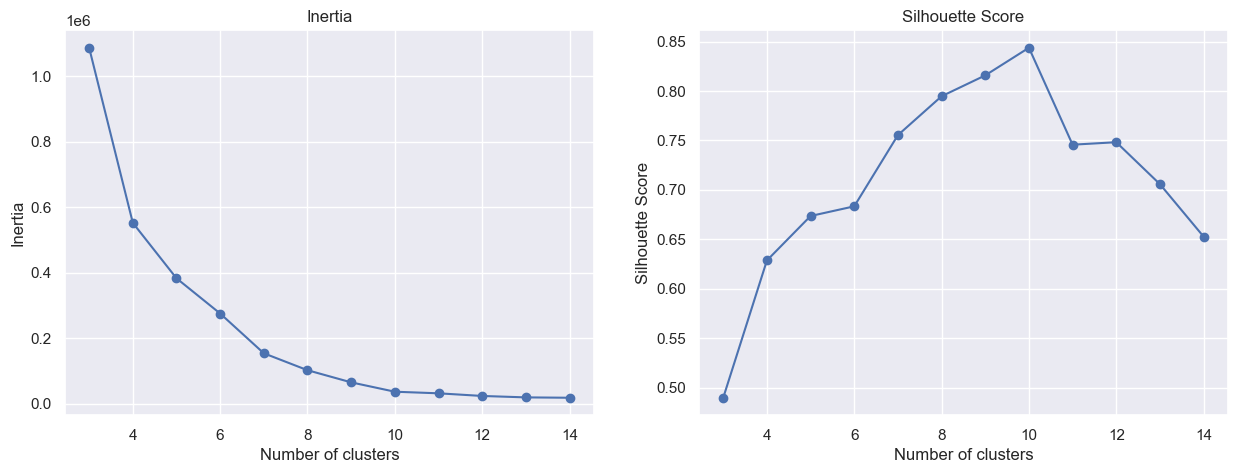

In [10]:
inertia_values = []
silhouette_scores = []

for num_clust in range(min_cluster,max_cluster+1):
    kmeans = KMeans(n_clusters=num_clust, random_state=42, n_init='auto').fit(projected_data)
    cluster_ids, cluster_sizes = np.unique(kmeans.labels_, return_counts=True)
    print(f"Number elements in {num_clust} clusters: {cluster_sizes}")
    inertia_values.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(projected_data, kmeans.labels_))

cluster_score_plots(min_cluster, max_cluster, inertia_values, silhouette_scores, 'figs/umap_kmeans_scores.png')


- The inertia scores don't show a clear elbow to decide number of clusters.

- The silhouette scores indicate that the number of clusters = 10.

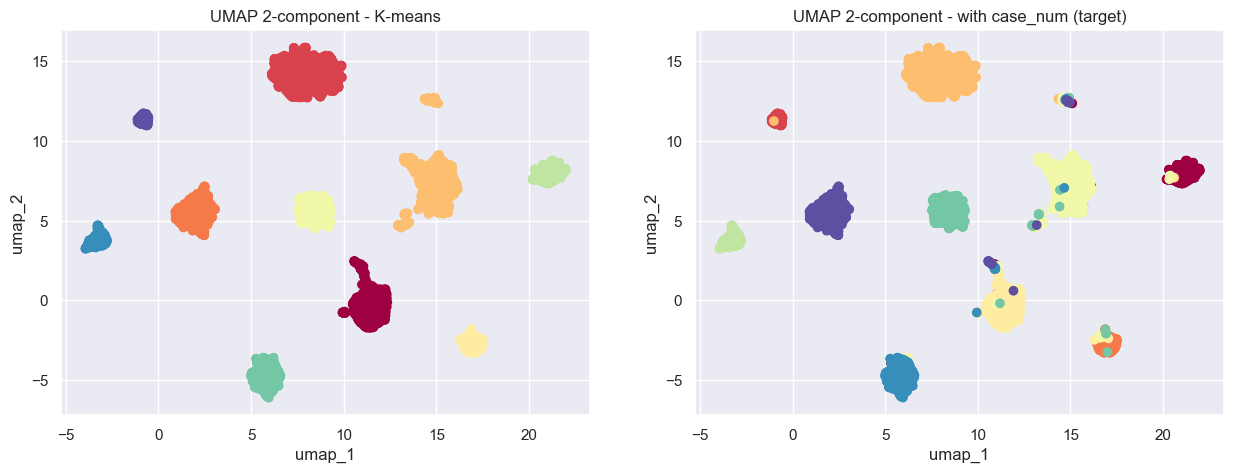

In [11]:
#plotting for kmeans 10 clusters and Checking against the target- case_num

kmeans = KMeans(n_clusters=10, random_state=42, n_init='auto').fit(projected_data)

sns.set(style="darkgrid")
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axes[0].scatter(red1['umap_1'],red1['umap_2'], c=kmeans.labels_, cmap='Spectral')
axes[0].set_title('UMAP 2-component - K-means')
axes[0].set_xlabel('umap_1')
axes[0].set_ylabel('umap_2')


axes[1].scatter(red1['umap_1'],red1['umap_2'], c=y, cmap='Spectral')
axes[1].set_title('UMAP 2-component - with case_num (target)')
axes[1].set_xlabel('umap_1')
axes[1].set_ylabel('umap_2')

plt.savefig('figs/umap_kmeans_casenum.png')
plt.show()

- We can see that there is overlap in patient case_num from the clusters formed.

- Considering the context of patient notes, this overlap might be due to the similar symptoms.

### Using T-SNE

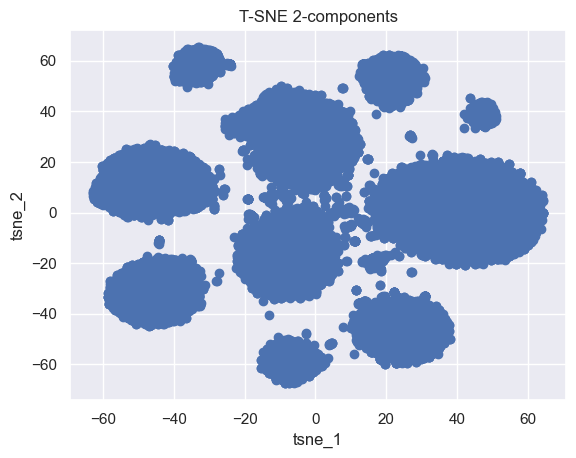

In [12]:
tsne = TSNE(n_components=2,  random_state = 42, init='random')
tsne_result = tsne.fit_transform(dtm)
red2 = pd.DataFrame(data=tsne_result, columns=['tsne1','tsne2'])
red2


plt.scatter(red2['tsne1'],red2['tsne2'])
plt.title('T-SNE 2-components')
plt.xlabel('tsne_1')
plt.ylabel('tsne_2')
plt.savefig('figs/tsne_2components.png')
plt.show()

Number elements in 3 clusters: [16486 11403 14257]
Number elements in 4 clusters: [10312 10627 10582 10625]
Number elements in 5 clusters: [ 9430 10590 10639  6385  5102]
Number elements in 6 clusters: [ 6076 10391 10390  6022  5082  4185]
Number elements in 7 clusters: [ 6039 10366  6007  6019  5082  4185  4448]
Number elements in 8 clusters: [ 6020 10366  5984  5082  1963  4078  4468  4185]
Number elements in 9 clusters: [5643 8131 6262 5082 1963 4082 3756 4185 3042]
Number elements in 10 clusters: [6714 1593 5913 5082 1963 4081 3932 4185 3041 5642]
Number elements in 11 clusters: [2071 6447 5505 5082 1963 4077 4132 4185 3041 4050 1593]
Number elements in 12 clusters: [2477 3312 5334 5082 1963 4057 4285 4185 3037 3376 1593 3445]
Number elements in 13 clusters: [2445 2323 5467 5082 1963 4057 4160 4185 3037 3391 1593 2890 1553]
Number elements in 14 clusters: [2445 2323 5467 5082 1963 4057 4160 2266 3037 3391 1593 2890 1553 1919]


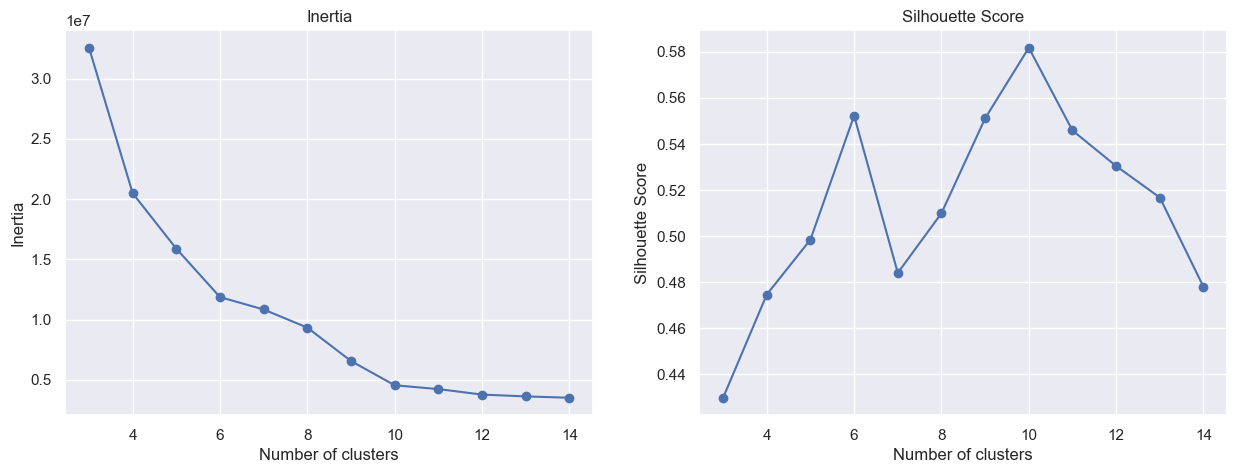

In [13]:
inertia_values = []
silhouette_scores = []

for num_clust in range(min_cluster,max_cluster+1):
    kmeans = KMeans(n_clusters=num_clust, random_state=42, n_init='auto').fit(tsne_result)
    cluster_ids, cluster_sizes = np.unique(kmeans.labels_, return_counts=True)
    print(f"Number elements in {num_clust} clusters: {cluster_sizes}")
    inertia_values.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(tsne_result, kmeans.labels_))

cluster_score_plots(min_cluster, max_cluster, inertia_values, silhouette_scores, 'figs/tsne_kmeans_scores.png')


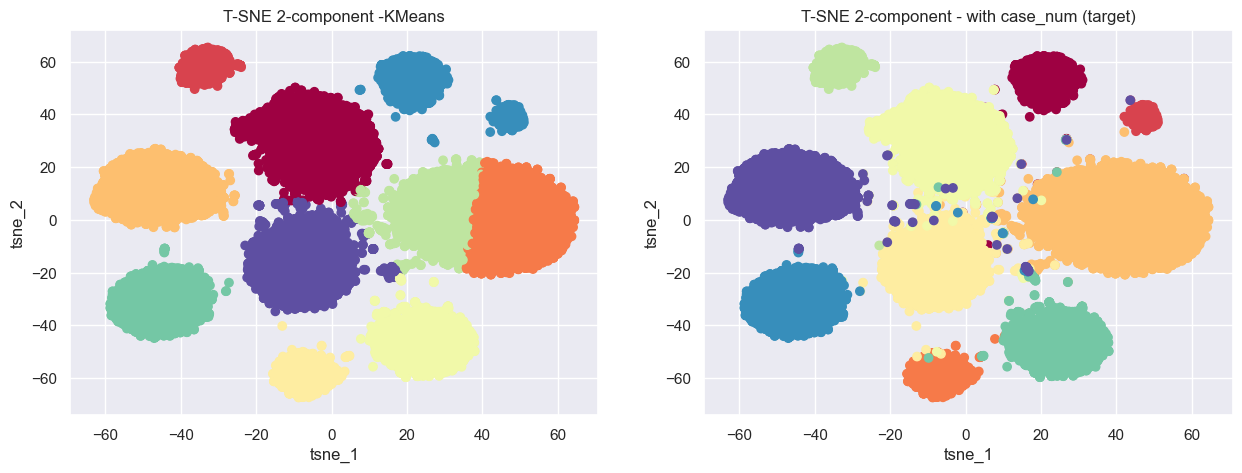

In [14]:
#plotting for kmeans 10 clusters and Checking against the target- case_num

kmeans = KMeans(n_clusters=10, random_state=42, n_init='auto').fit(tsne_result)

sns.set(style="darkgrid")
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axes[0].scatter(red2['tsne1'],red2['tsne2'], c=kmeans.labels_, cmap='Spectral')
axes[0].set_title('T-SNE 2-component -KMeans')
axes[0].set_xlabel('tsne_1')
axes[0].set_ylabel('tsne_2')


axes[1].scatter(red2['tsne1'],red2['tsne2'], c=y, cmap='Spectral')
axes[1].set_title('T-SNE 2-component - with case_num (target)')
axes[1].set_xlabel('tsne_1')
axes[1].set_ylabel('tsne_2')
plt.savefig('figs/tnse_kmeans_casenum.png')
plt.show()

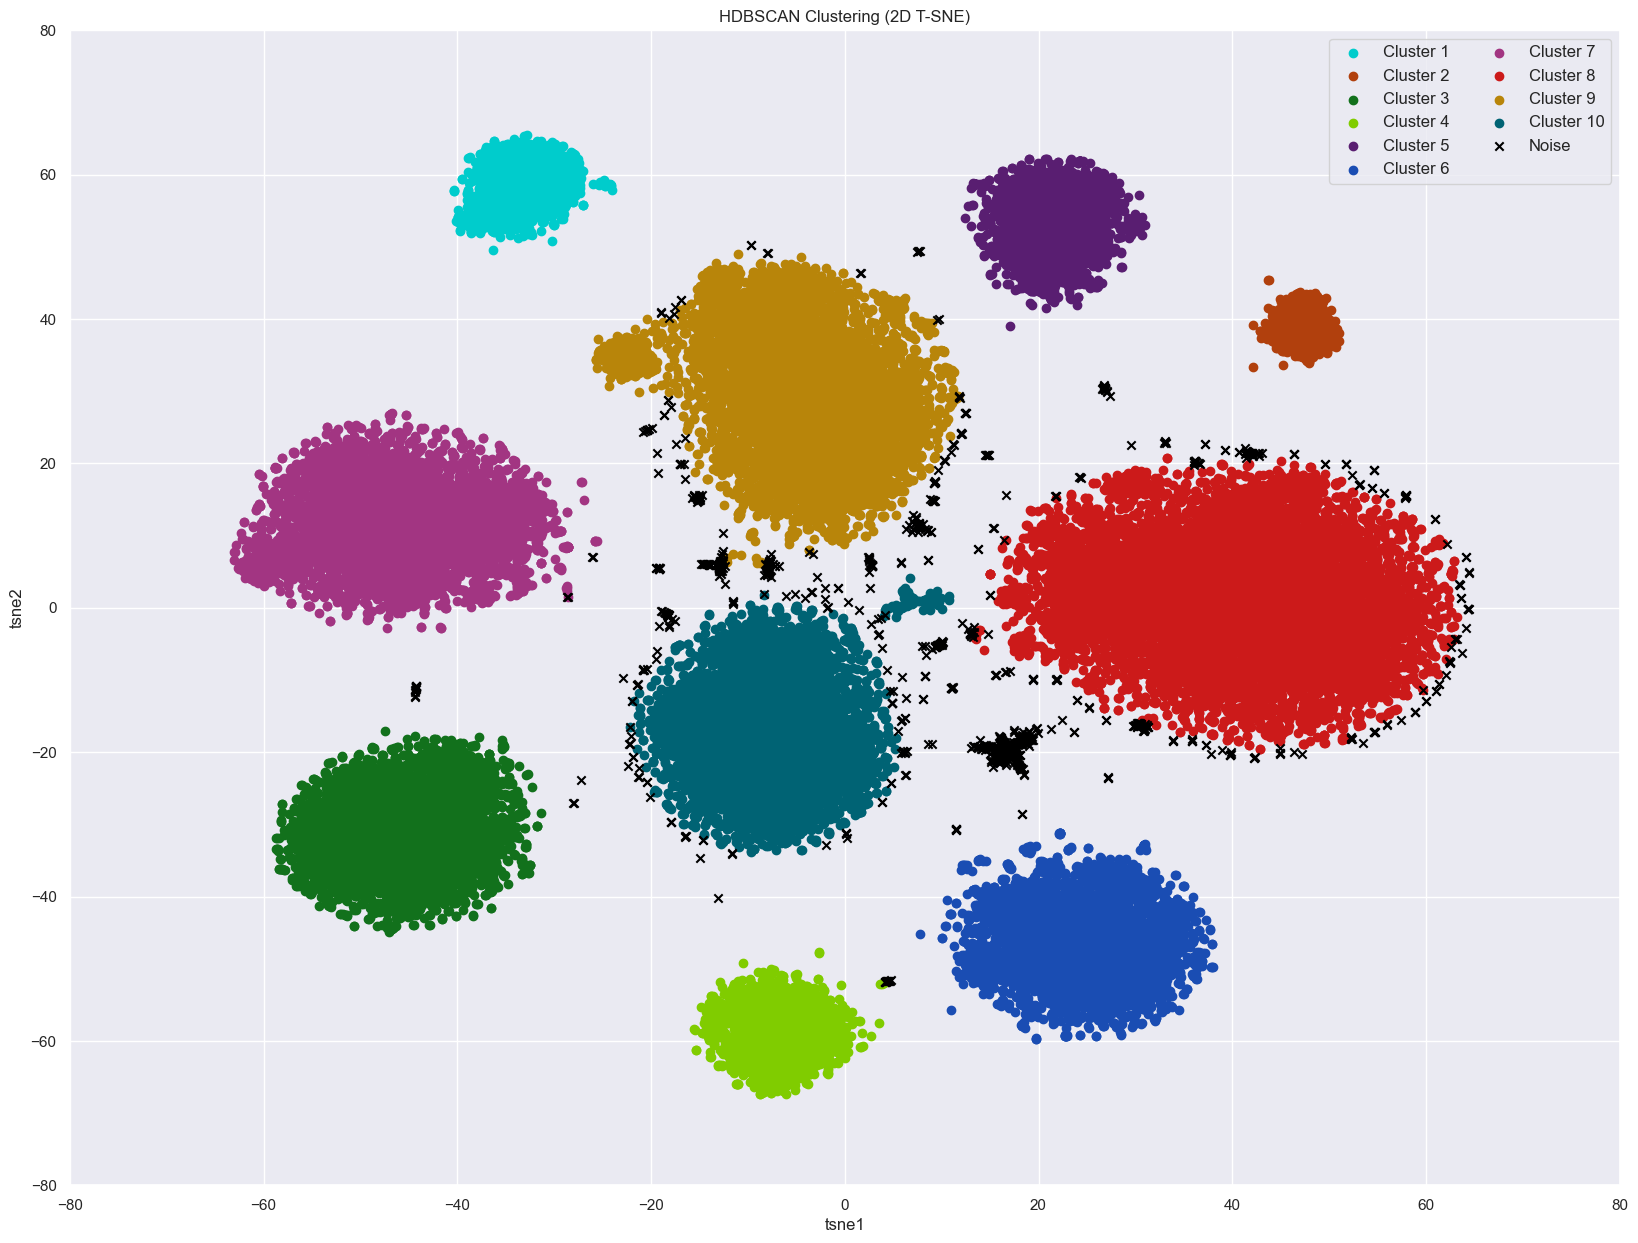

In [15]:
from sklearn.cluster import HDBSCAN
import seaborn as sns

hdb_tsne = HDBSCAN(min_cluster_size=500, min_samples = 100)
cluster_labels = hdb_tsne.fit_predict(red2)

plt.figure(figsize = (20,15))

palette = sns.color_palette('dark', np.unique(cluster_labels).max() + 1)
palette[7] = (0.8, 0.1, 0.1)
palette[5] = (0.1, 0.3, 0.7)
palette[3] = (0.5, 0.8, 0)
palette[0] = (0, 0.8, 0.8)

#plotting clusters
for i in range(np.unique(cluster_labels).max() + 1):
    plt.scatter(red2[cluster_labels == i]['tsne1'], red2[cluster_labels == i]['tsne2'], color = palette[i], label = f'Cluster {i+1}')

#plotting noise
plt.scatter(red2[cluster_labels == -1]['tsne1'], red2[cluster_labels == -1]['tsne2'], color = 'black', marker = 'x', label = f'Noise')


plt.title('HDBSCAN Clustering (2D T-SNE)')
plt.xlabel('tsne1')
plt.ylabel('tsne2')
plt.xlim(-80, 80)
plt.ylim(-80, 80)
plt.legend(loc = 'best', fontsize = 'medium', ncols =2)
plt.savefig('figs/hdbscan_clusters.png')
plt.show()